## Tutorial for multivariate climate data

Import required packages

In [2]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Import library specific modules
sys.path.append("../../")
from library.spod_low_storage import SPOD_low_storage
from library.spod_low_ram     import SPOD_low_ram
from library.spod_streaming   import SPOD_streaming
import library.weights as weights

# Current, parent and file paths
CWD = os.getcwd()

In [3]:
# Inspect and load data 
file = '/Users/gian/Desktop/SEOF_reanalysis-master/data/E20C/E20C_MONTHLYMEAN00_1900_2010_MEI.nc'

# Data is in netCDF format: 
# we use xarray to load the dataset and extract its content
ds = xr.open_dataset(file)

# Let's take a look at its content
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-25 20:57:11 GMT by grib_to_netcdf-2.19.0: grib_to_n...


the netCDF file contains 3 coordinates:
- longitude
- latitude, and 
- time, 

along with 6 variables

- sst (sea surface temperature)
- msl (mean seal level pressure)
- tcc (total cloud cover)
- u10 (horizontal velocity; u-component)
- v10 (horizontal velocity; v-component)
- t2m (2-meters temperature)

In [4]:
# we set the variables we want to use for the analysis
# (we select all the variables present)
variables = ['sst', 'msl', 'tcc', 'u10', 'v10', 't2m']

# we extract time, longitude and latitude
t = np.array(ds['time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])

# and load data in RAM 
X = np.empty([t.shape[0], x1.shape[0], x2.shape[0], len(variables)])
for i,var in enumerate(variables):
	X[...,i] = np.einsum('ijk->ikj', np.array(ds[var]))
	X[...,i] = np.nan_to_num(X[...,i])

# let's take a look at the shape of the data loaded in memory
print(X.shape)

(1332, 240, 121, 6)


Note that: 
- the first dimension is 1332, and corresponds to the number of time snapshots; 
- the second is 240, and corresponds to the longitude points;
- the third is 121, and corresponds to the latitude point;
- the fourth is 6, and corresponds to the number of variables.

Indeed, we use as first dimension the number of time snapshots, as last dimension the number of variables and as middle dimensions, the spatial dimensions, that in our case are two and correspond to longitude and latitude.

In [9]:
# define required and optional parameters
params = dict()

# required parameters
params['dt'          ] = 720 # data time-sampling
params['nt'          ] = 300 # number of time snapshots
params['xdim'        ] = 2   # number of spatial dimensions (longitude and latitude)
params['nv'          ] = len(variables)           # number of variables
params['n_FFT'       ] = np.ceil(12 * 5)          # length of FFT blocks
params['n_freq'      ] = params['n_FFT'] / 2 + 1  # number of frequencies 
params['n_overlap'   ] = np.ceil(params['n_FFT'] * 0 / 100) # dimension block overlap region
params['mean'        ] = 'blockwise' # type of mean to subtract to the data
params['normalize'   ] = True        # normalization of weights by data variance 
params['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results
params['weights'] = weights.geo_weights_trapz_2D(\
    lat=x2, 
    lon=x1, 
    R=1, 
    n_vars=params['nv']) # weights

# optional parameters
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = False  # save FFT blocks to reuse them in the future (saves time)

# Normalize data if required
if params['normalize']:
	params['weights'] = \
        weights.apply_normalization(\
            X=X, 
            weights=params['weights'], 
            method='variance')


Normalization by variance
-------------------------
6
18430.11636783917
997898.3742039748
0.045647031214025205
14.229572645179967
5.8917597036689555
463.1162835656313


In [10]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_storage(X=X, params=params, file_handler=False)
spod = SPOD_analysis.fit()


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  60
Block overlap             :  0
No. of blocks             :  5
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  user-specified
Mean                      :  blockwise
Time-step                 :  720
Number of Frequencies     :  31
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.38945674896240295 GB. (double)
data matrix dimensions:         (1332, 240, 121, 6)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1332 must correspond to number of time snapshots.
Last column dimension: 6 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
Checking if blocks are already present ...
... block

computing frequencies:   0%|          | 0/31 [00:00<?, ?it/s]

Elapsed time 0.4  0.13023805618286133 s.
Elapsed time 0.5  4.76837158203125e-06 s.
Elapsed time 0.6  0.025427818298339844 s.
Elapsed time 0.7  0.02937602996826172 s.
--------------------------------------
Elapsed time 2.  1.4588589668273926 s.
 
Calculating SPOD (low_storage)
--------------------------------------


computing frequencies: 100%|██████████| 31/31 [00:01<00:00, 20.37it/s]

--------------------------------------
 
Elapsed time 3.  1.556959867477417 s.
Results saved in folder  /Users/gian/GIT-GM/pyspod/tutorials/climate/results/E20C_MONTHLYMEAN00_1900_2010_MEI/nfft60_novlp0_nblks5
Elapsed time:  3.0235297679901123 s.


In [11]:
# Show results
T_approx = 876 # approximate period (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

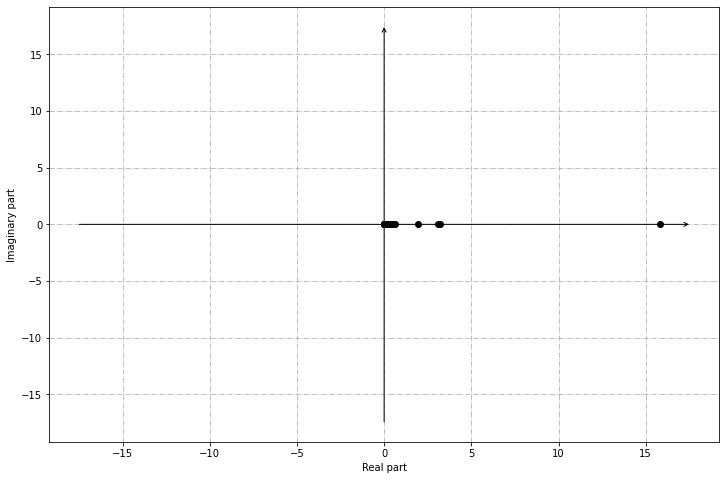

In [12]:
spod.plot_eigs()

../../library/postprocessing.py:250: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(1.1*xlim_min, 1.1*xlim_max)


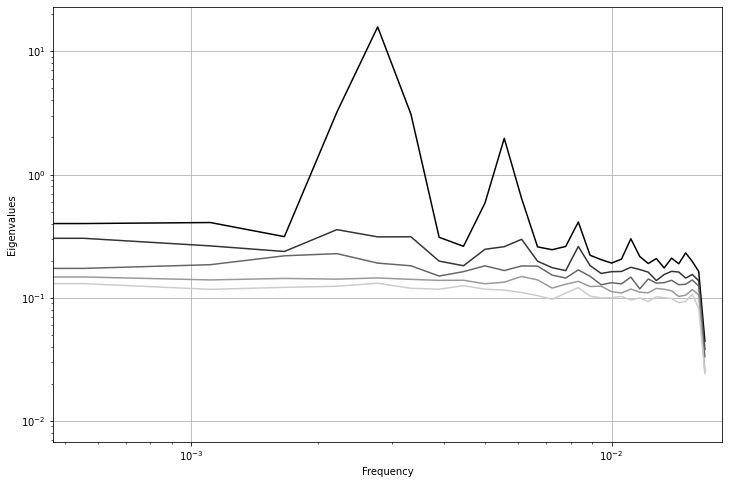

In [13]:
freq = spod.freq*24
spod.plot_eigs_vs_frequency(freq=freq)

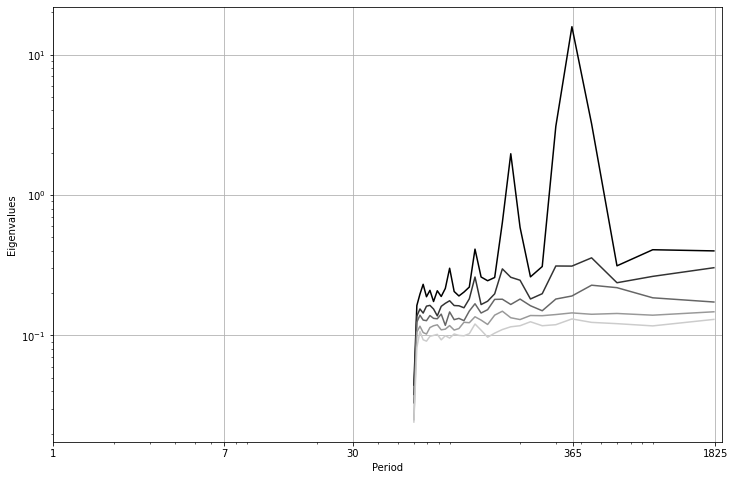

In [14]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

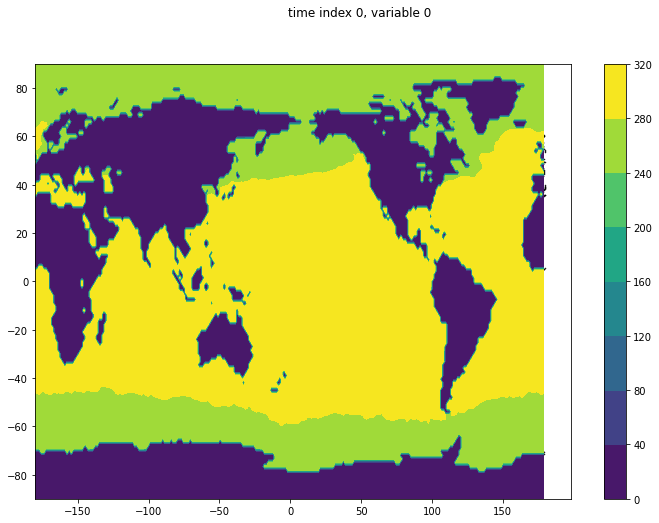

In [18]:
spod.plot_2D_data(x1=x1-180, x2=x2, coastlines='centred')

In [20]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=x1, x2=x2, coastlines='centred')

TypeError: plot_2D_modes_at_frequency() got an unexpected keyword argument 'coastlines'